In [1]:
# import functions
import os                                                                       # work with absolute directory path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import missingno as msno                                                        # visualize missing data
from statsmodels.stats.outliers_influence import variance_inflation_factor      # compute VIF

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import plotly.io as pio
from sklearn.impute import SimpleImputer

# set display and graphics
pd.set_option('display.max_columns', None)  
sns.set(style = "whitegrid")                                                    # set the style for the plot
sns.set_context("paper")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"                                 # display output for all lines within a cell

# define working directory path
path_workdir = '/Users/azfar/Documents/Python/Health Data Analytics Using Python/Project'
path_fig = '/Users/azfar/Documents/Python/Health Data Analytics Using Python/Project/Paper/figure'

In [2]:
# Load data file
dfa = pd.read_csv('/Users/azfar/Documents/Python/Health Data Analytics Using Python/Project/add1120_prep3.csv')
dfa = dfa.drop_duplicates(subset='mepsid')      # get unique cases
dfa = dfa.drop('mepsid', axis=1)                # drop case identifier

# Machine learning classification

ML Pre-process

In [3]:
# create dataframe
df_ml = dfa

# create all numeric data frame
object_columns = df_ml.select_dtypes(include=['object'])          # Select columns with the "object" data type
dummy_columns = pd.get_dummies(object_columns)                    # Get dummy variables for the selected columns 
df_ml = df_ml.drop(object_columns, axis=1)                        # Drop the object variables
df_mlnum = pd.concat([df_ml, dummy_columns], axis = 1)            # Concatenate the dummy columns with the original DataFrame
#   df_mlnum = df_mlnum.drop('hinotcov_No', axis=1)                   # Drop negation of target 
print(df_mlnum.dtypes)

age                                                float64
famsize                                            float64
ftotincmeps                                        float64
inctot                                             float64
ftotval                                            float64
                                                    ...   
povcat_High income (>=400% of poverty line)          uint8
povcat_Low income (125-199% of poverty line)         uint8
povcat_Middle income (200-399% of poverty line)      uint8
povcat_Near poor (100-124% of poverty line)          uint8
povcat_Negative or poor (<100% of poverty line)      uint8
Length: 87, dtype: object


ML setup

In [4]:
# Create numpy arrays for feature and target
X = df_mlnum.drop('hinotcov_Yes',axis=1).values               # feature
Y = df_mlnum['hinotcov_Yes'].values                           # target

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape
Y.shape

# Create test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 111)   
"""
# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)
"""
X_train.shape
Y_train.shape

(184573, 86)

(184573,)

"\n# Impute missing values with the mean\nimputer = SimpleImputer(strategy='mean')\nX_train = imputer.fit_transform(X_train)\nX_test = imputer.fit_transform(X_test)\n"

(147658, 86)

(147658,)

# Decision Tree ML classification

Plot a curve with training and test accuracy varying max_depth

Text(0.5, 0, 'Max_depth')

Text(0, 0.5, 'Accuracy')

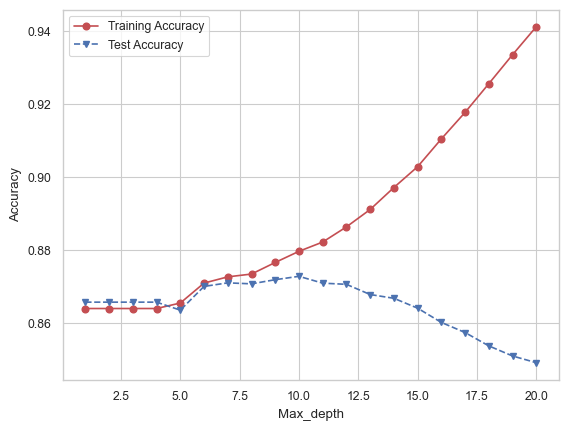

In [5]:
max_depthlist = list(range(1, 21))          # List of max_depth
trainAcc = []                               # Empty list to store training accuracy
testAcc = []                                # Empty list to store testing accuracy

# a loop for collecting training and testing accuracies for varying max_depth
for k in max_depthlist:
    clf = tree.DecisionTreeClassifier(max_depth = k, random_state = 0)
    clf = clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    trainAcc.append(accuracy_score(Y_train, Y_predTrain))
    Y_predTest = clf.predict(X_test)
    testAcc.append(accuracy_score(Y_test, Y_predTest))
    # end of for loop statement

plt.plot(max_depthlist, trainAcc, 'ro-', max_depthlist, testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(path_fig, 'dt_accuracy_varydepth.png'))

Use a 10-fold CV to select the two best parameters (max_depth and min_samples_split)

In [6]:
param_grid = {
    'max_depth': range(1, 16, 2),                                           # Start with 1, end with 15, increment by 2
    'min_samples_split': range(5, 61, 5)                                    # Start with 5, end with 60, increment by 5
}

clf = DecisionTreeClassifier(random_state=0)                                # Create a decision tree classifier
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')      # Create the GridSearchCV object
grid_search.fit(X_train, Y_train)                                           # Fit the grid search to the data
print("Best Parameters: ", grid_search.best_params_)                        # Print the best parameters
best_clf = grid_search.best_estimator_                                      # Get the best estimator

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': range(1, 16, 2),
                         'min_samples_split': range(5, 61, 5)},
             scoring='accuracy')

Best Parameters:  {'max_depth': 9, 'min_samples_split': 50}


Use the best parameters from step b, run the classifier using training data set and evaluate with test data set. 

In [7]:
best_max_depth = grid_search.best_params_['max_depth']                  # get best max_depth
best_min_samples_split = grid_search.best_params_['min_samples_split']  # get best min_samples_split

best_clf = DecisionTreeClassifier(max_depth = best_max_depth, min_samples_split = best_min_samples_split, random_state = 0)   # Run the decision tree classifier with the best parameters

best_clf.fit(X_train, Y_train)                                 # Train the classifier on the training dataset
Y_pred_train = best_clf.predict(X_train)                       # Make predictions on the training set
train_accuracy_dt = accuracy_score(Y_train, Y_pred_train)      # Evaluate training accuracy
print("Training Accuracy:", train_accuracy_dt)
Y_pred_test = best_clf.predict(X_test)                         # Make predictions on the test set
test_accuracy_dt = accuracy_score(Y_test, Y_pred_test)         # Evaluate test accuracy
print("Test Accuracy:", test_accuracy_dt)

DecisionTreeClassifier(max_depth=9, min_samples_split=50, random_state=0)

Training Accuracy: 0.8756992509718403
Test Accuracy: 0.8719490721928755


Cross-table (confusion matrix) with true and predicted labels from test data

<Figure size 1000x400 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix (Training Set)')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix (Test Set)')

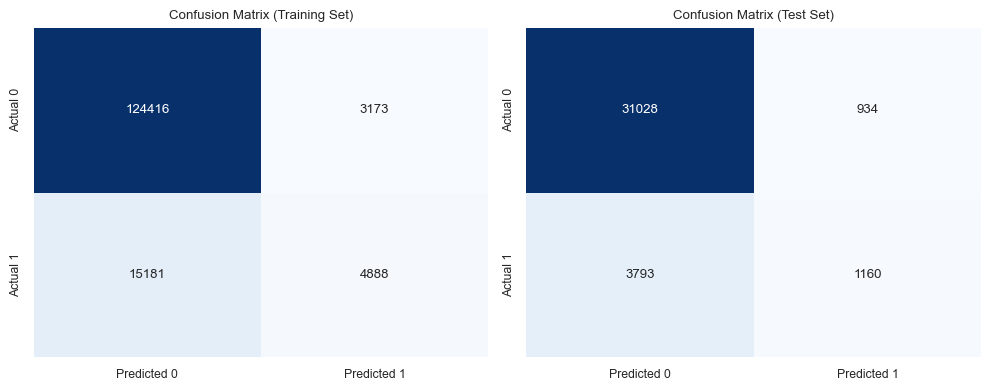

In [10]:
conf_matrix_train = confusion_matrix(Y_train, Y_pred_train)              # Confusion Matrix for training data
class_report_train = classification_report(Y_train, Y_pred_train)        # Classification Report for training data
conf_matrix_test = confusion_matrix(Y_test, Y_pred_test)                 # Confusion Matrix for test data
class_report_test = classification_report(Y_test, Y_pred_test)           # Classification Report for test data

# Visualize Confusion Matrix
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Training Set)')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Test Set)')

plt.tight_layout()
plt.savefig(os.path.join(path_fig, 'dt_confmat.png'))
plt.show()

Accuracy, sensitivity and specificity

In [ ]:
def calculate_metrics(conf_matrix):                                         # Define a function to calculate sensitivity and specificity
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    true_negatives = conf_matrix[0, 0]
    false_negatives = conf_matrix[1, 0]

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    return accuracy, sensitivity, specificity


accuracy_train, sensitivity_train, specificity_train = calculate_metrics(conf_matrix_train)     # Calculate metrics for training set


accuracy_test, sensitivity_test, specificity_test = calculate_metrics(conf_matrix_test)         # Calculate metrics for test set


print("Training Set Metrics:")                                                                  # Print the results
print("Accuracy:", accuracy_train)
print("Sensitivity:", sensitivity_train)
print("Specificity:", specificity_train)

print("\nTest Set Metrics:")
print("Accuracy:", accuracy_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)

accuracy_train, sensitivity_train, specificity_train = calculate_metrics(conf_matrix_train)
accuracy_test, sensitivity_test, specificity_test = calculate_metrics(conf_matrix_test)

# Create a table in LaTeX format
table_data = [['Metric', 'Training Set', 'Test Set'],
              ['Accuracy', accuracy_train, accuracy_test],
              ['Sensitivity', sensitivity_train, sensitivity_test],
              ['Specificity', specificity_train, specificity_test]]

table_latex = tabulate(table_data, tablefmt="latex_raw")

file_path = os.path.join(path_fig, 'dt_table_acc_sens_spec.tex')     # Specify the file path using os.path.join
with open(file_path, 'w') as file:
    file.write(table_latex)                                          # Save the LaTeX table to the specified file path
print(f"Table saved to '{file_path}'")

Find the important features and plot the features with important score

In [ ]:
print("Feature importances:\n{}".format(best_clf.feature_importances_))

important_features_dict = {}
for x,i in enumerate(best_clf.feature_importances_):
    important_features_dict[x]=i

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print ('Most important features: %s' %important_features_list)

# get the sorted feature list based on importance scores
# create an empty dictionary of features and importance scores
featureImpList= []
feature_names=list(df_mlnum.columns[0:109])

for feat, importance in zip(feature_names, best_clf.feature_importances_):  
        if importance > .001:
            temp = [feat, importance*100]
            featureImpList.append(temp)

# create a dataframe
fT_df = pd.DataFrame(featureImpList, columns = ['Feature', 'Importance'])
# sort the values
fT_df_sorted = fT_df.sort_values('Importance', ascending = False)
print (fT_df_sorted)

# plot the sorted importances 
plt.figure(figsize=(8,6))
n_features = len(fT_df_sorted)
plt.barh(range(n_features), fT_df_sorted['Importance'], align='center')
plt.yticks(np.arange(n_features), fT_df_sorted['Feature'])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)
plt.savefig(os.path.join(path_fig, 'dt_important_elements.png'))